In [1]:
library(ggplot2)
library(zoo)
library(sqldf)
library(rpart)
library(glmnet)
library(MLmetrics)


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: gsubfn

Loading required package: proto

Warning message:
“no DISPLAY variable so Tk is not available”
Loading required package: RSQLite

Loading required package: Matrix

Loaded glmnet 4.1-4


Attaching package: ‘MLmetrics’


The following object is masked from ‘package:base’:

    Recall




In [2]:
train <- read.csv("../input/auto-share-demand-time-series/timeseries_autosharing_train.csv")
test <- read.csv("../input/auto-share-demand-time-series/timeseries_autosharing_test.csv")

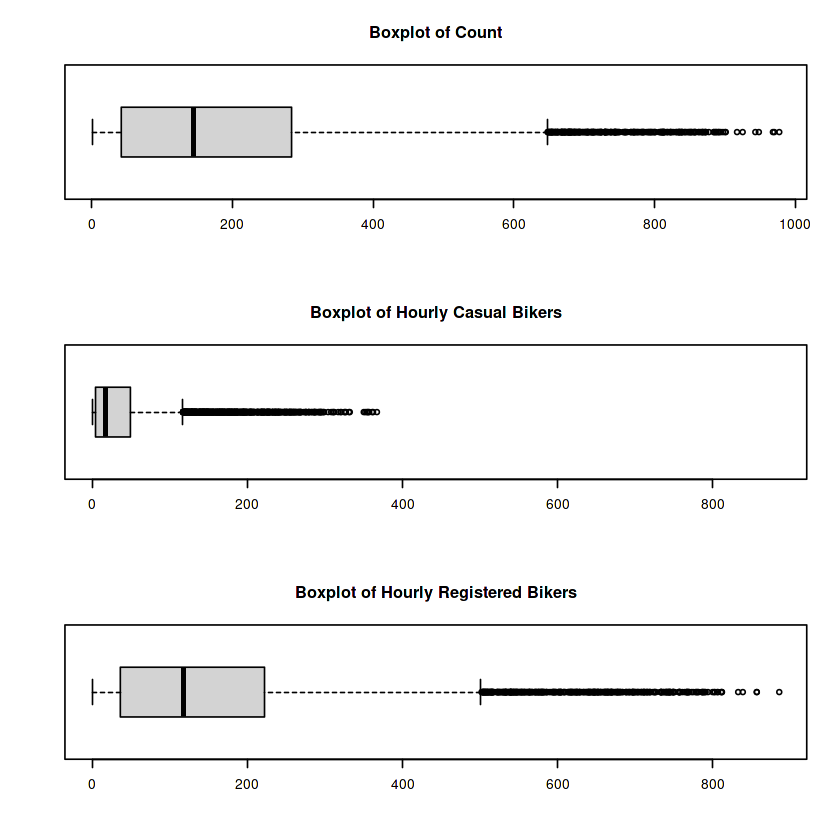

In [3]:
par(mfrow=c(3, 1))
boxplot(train$count, horizontal = T, main="Boxplot of Count")
lmts <- range(train$registered)
boxplot(train$casual, ylim=lmts, horizontal=T, main="Boxplot of Hourly Casual Bikers")
#hist(train$casual, main="Histogram of Casual Bikers", xlab="Hourly Rentals")
boxplot(train$registered, ylim=lmts, horizontal=T, main="Boxplot of Hourly Registered Bikers")

In [4]:
train$is_count_outlier <- ifelse(train$count > (1.5*IQR(train$count)), 1, 0)
train$is_casual_outlier <- ifelse(train$casual > (1.5*IQR(train$casual)), 1, 0)
train$is_registered_outlier <- ifelse(train$registered > (1.5*IQR(train$registered)), 1, 0)

In [5]:
train$hour <- as.factor(substring(train$datetime, 12, 13))
test$hour <- as.factor(substring(test$datetime, 12, 13))
train$day <- as.factor(weekdays(as.Date(train$datetime)))
test$day <- as.factor(weekdays(as.Date(test$datetime)))
train$year <- (format(as.Date(as.Date(train$datetime), format="%d/%m/%Y"),"%Y"))
test$year <- (format(as.Date(as.Date(test$datetime), format="%d/%m/%Y"),"%Y"))

In [6]:
train$date <- as.Date(train$datetime)
test$date <- as.Date(test$datetime)

In [7]:
counts_by_date <- aggregate(list(train["registered"], train["casual"], train["count"]), by=train["date"], sum)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



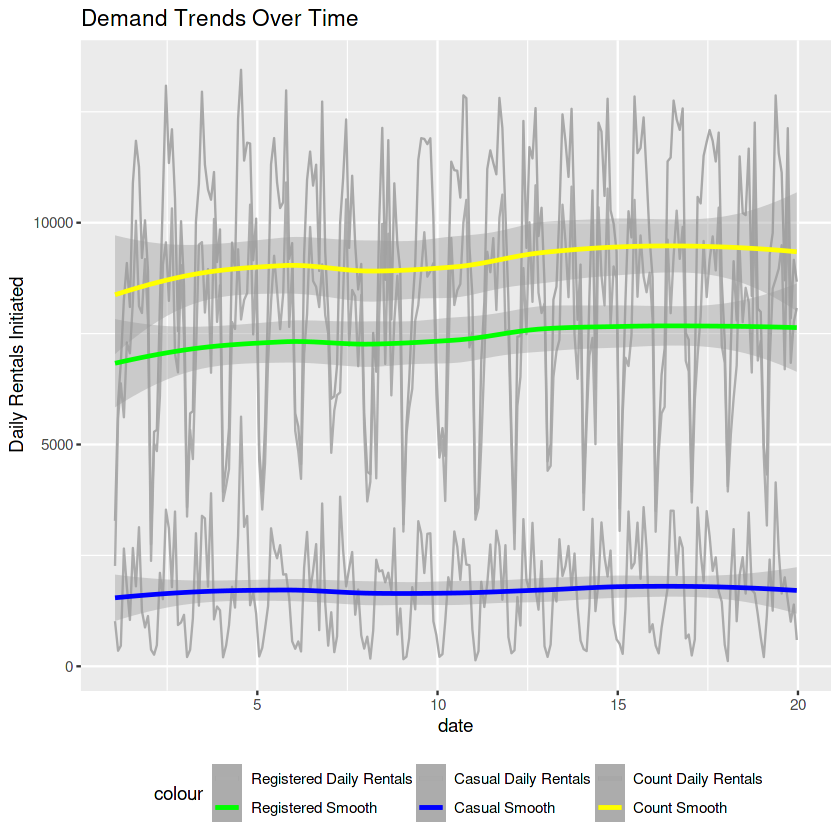

In [8]:
time_plot <- ggplot(counts_by_date, aes(x=date))+
  geom_line(aes(y = registered, colour = "Registered Daily Rentals"))+
  geom_line(aes(y = casual, colour = "Casual Daily Rentals"))+
  geom_line(aes(y = count, colour = "Count Daily Rentals"))+
  geom_smooth(aes(y = registered, colour = "Registered Smooth"))+
  geom_smooth(aes(y = casual, colour = "Casual Smooth"))+
  geom_smooth(aes(y = count, colour = "Count Smooth"))+
  scale_colour_manual(values=c("Registered Daily Rentals"="grey68", "Registered Smooth"="green", "Casual Daily Rentals"="grey67", "Casual Smooth"="blue", "Count Daily Rentals"="grey66", "Count Smooth"="yellow"))
time_plot + labs(y="Daily Rentals Initiated", title="Demand Trends Over Time") + theme(legend.position = "bottom")

In [9]:
train$quarter_year <- as.yearqtr(as.Date(train$date, "%m/%d/%Y"))
test$quarter_year <- as.yearqtr(as.Date(test$date,  "%m/%d/%Y"))

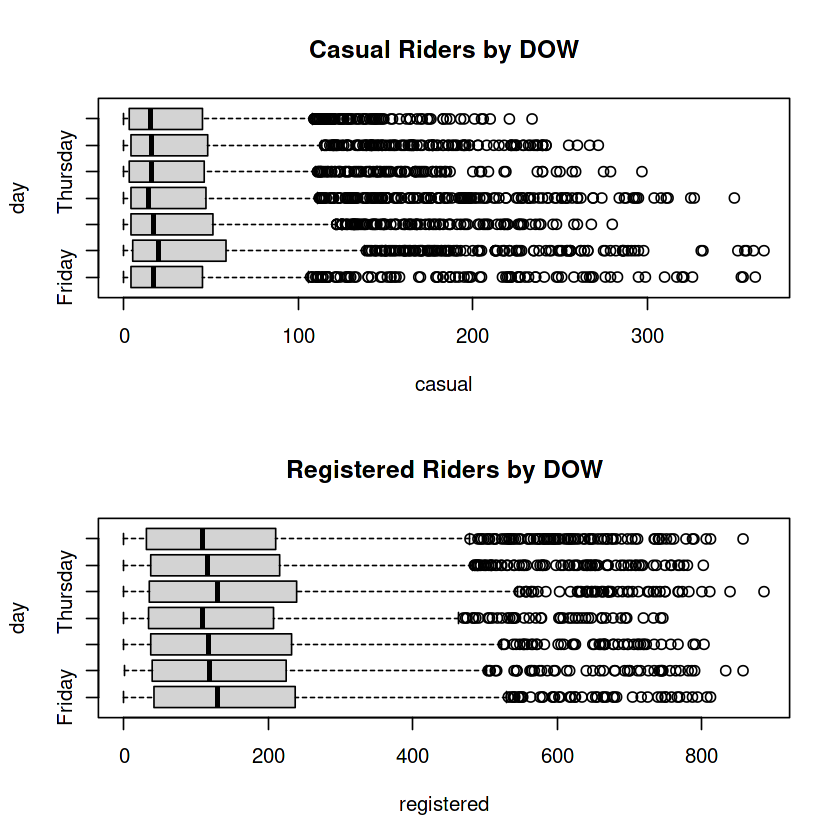

In [10]:
par(mfrow=c(2,1))
boxplot(casual~day, data=train, main = "Casual Riders by DOW", horizontal = T)
boxplot(registered~day, data=train, main = "Registered Riders by DOW", horizontal = T)

In [11]:
outlier_counts <- sqldf("select day, sum(is_casual_outlier) as casual_outliers, sum(is_registered_outlier) as registered_outliers from train group by day")
outlier_counts

day,casual_outliers,registered_outliers
<fct>,<dbl>,<dbl>
Friday,233,297
Monday,311,237
Saturday,294,270
Sunday,290,213
Thursday,233,286
Tuesday,272,250
Wednesday,226,236


In [12]:
days = c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")
for (day in days){
  standev = sd(train$casual[which(train$day == day)])
  message(day,' =  ', standev)
}

Monday =  61.5449699235058

Tuesday =  48.4434536210186

Wednesday =  37.592914062603

Thursday =  42.6659995799932

Friday =  49.5983507779131

Saturday =  47.807122212586

Sunday =  57.7724988450305



In [13]:
days = c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")
for (day in days){
  standev = sd(train$registered[which(train$day == day)])
  message(day,' =  ', standev)
}

Monday =  148.612905698294

Tuesday =  150.101060128929

Wednesday =  158.191992994852

Thursday =  161.804617820323

Friday =  151.306302026812

Saturday =  150.210738816968

Sunday =  134.720637461094



In [14]:
train$casual_outlier_day = as.factor(ifelse(train$day == "Saturday" | train$day == "Sunday", 1, 0))
test$casual_outlier_day = as.factor(ifelse(test$day == "Saturday" | test$day == "Sunday", 1, 0))
train$registered_outlier_day = as.factor(ifelse(train$day == "Saturday" | train$day == "Sunday", 0, 1))
test$registered_outlier_day = as.factor(ifelse(test$day == "Saturday" | test$day == "Sunday", 0, 1))

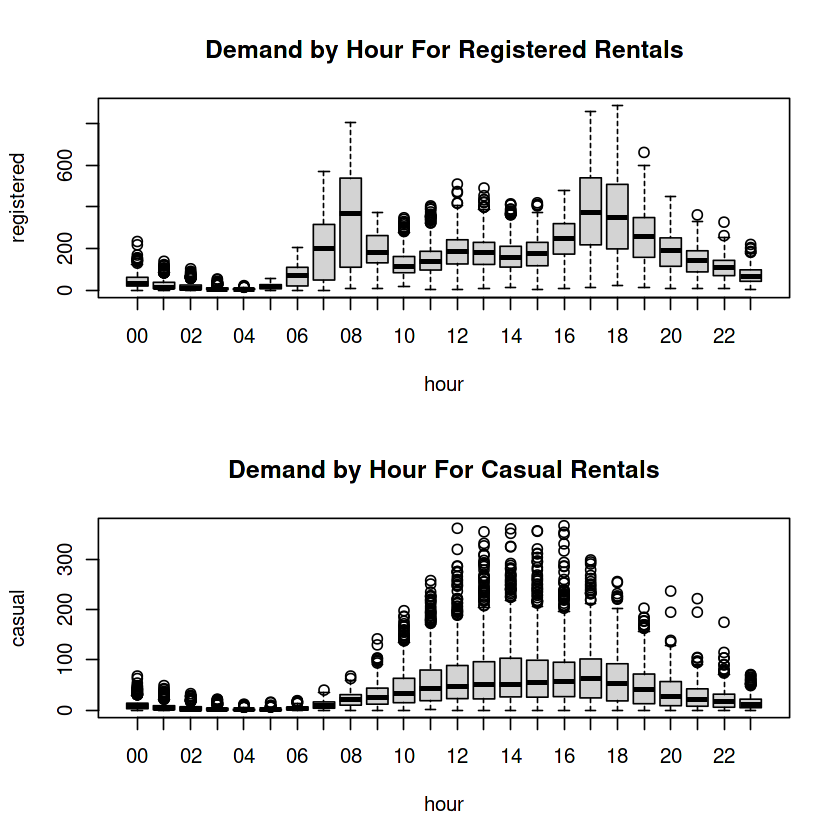

In [15]:
par(mfrow=c(2, 1))
boxplot(registered~hour, data=train, main = "Demand by Hour For Registered Rentals")
boxplot(casual~hour, data=train, main = "Demand by Hour For Casual Rentals")

In [16]:
train$hour <- as.integer(train$hour)
test$hour <- as.integer(test$hour)

In [17]:
r=rpart(registered~hour,data=train)
c=rpart(casual~hour, data=train)
r_bins_train <- predict(r, train)
c_bins_train <- predict(c, train)
r_bins_test <- predict(r, test)
c_bins_test <- predict(c, test)

In [18]:
train <- cbind(train, 
               hour_bin_registered = as.factor(round(r_bins_train, 2)), 
               hour_bin_casual = as.factor(round(c_bins_train, 2)))
test <- cbind(test, 
              hour_bin_registered = as.factor(round(r_bins_test, 2)), 
              hour_bin_casual = as.factor(round(c_bins_test, 2)))

In [19]:
nums <- unlist(lapply(train, is.numeric))
nums = train[,nums]
cor(nums)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,is_count_outlier,is_casual_outlier,is_registered_outlier,hour
season,1.000000000,0.0293676097,-0.008126058,0.008878651,0.2586885508,0.264744326,0.190610020,-0.147121209,0.09675806,0.16401053,0.163439017,0.11354751,0.07222035,0.12030024,-0.0065456741
holiday,0.029367610,1.0000000000,-0.250491391,-0.007073912,0.0002946034,-0.005214778,0.001928711,0.008408738,0.04379893,-0.02095567,-0.005392984,0.01960281,0.04086903,-0.01057885,-0.0003541611
workingday,-0.008126058,-0.2504913912,1.000000000,0.033771842,0.0299655472,0.024660329,-0.010879845,0.013373313,-0.31911096,0.11945985,0.011593866,-0.03407984,-0.26171185,0.10365203,0.0027802345
weather,0.008878651,-0.0070739115,0.033771842,1.000000000,-0.0550354182,-0.055375973,0.406243651,0.007261124,-0.13591768,-0.10934037,-0.128655201,-0.09593565,-0.11279364,-0.07961471,-0.0227403355
temp,0.258688551,0.0002946034,0.029965547,-0.055035418,1.0000000000,0.984948110,-0.064948771,-0.017852010,0.46709706,0.31857128,0.394453645,0.27909487,0.39306457,0.21364569,0.1454296695
atemp,0.264744326,-0.0052147782,0.024660329,-0.055375973,0.9849481105,1.000000000,-0.043535709,-0.057473002,0.46206654,0.31463539,0.389784437,0.27385809,0.38396290,0.21149701,0.1403425504
humidity,0.190610020,0.0019287112,-0.010879845,0.406243651,-0.0649487709,-0.043535709,1.000000000,-0.318606992,-0.34818690,-0.26545787,-0.317371479,-0.20830579,-0.30148307,-0.15042184,-0.2780113850
windspeed,-0.147121209,0.0084087378,0.013373313,0.007261124,-0.0178520099,-0.057473002,-0.318606992,1.000000000,0.09227619,0.09105166,0.101369470,0.06265747,0.07646384,0.05745279,0.1466312785
casual,0.096758063,0.0437989287,-0.319110963,-0.135917680,0.4670970641,0.462066536,-0.348186899,0.092276189,1.00000000,0.49724969,0.690413565,0.57894375,0.80934662,0.37848956,0.3020454019
registered,0.164010534,-0.0209556729,0.119459851,-0.109340372,0.3185712803,0.314635386,-0.265457868,0.091051662,0.49724969,1.00000000,0.970948106,0.76808167,0.43115107,0.79719961,0.3805397262


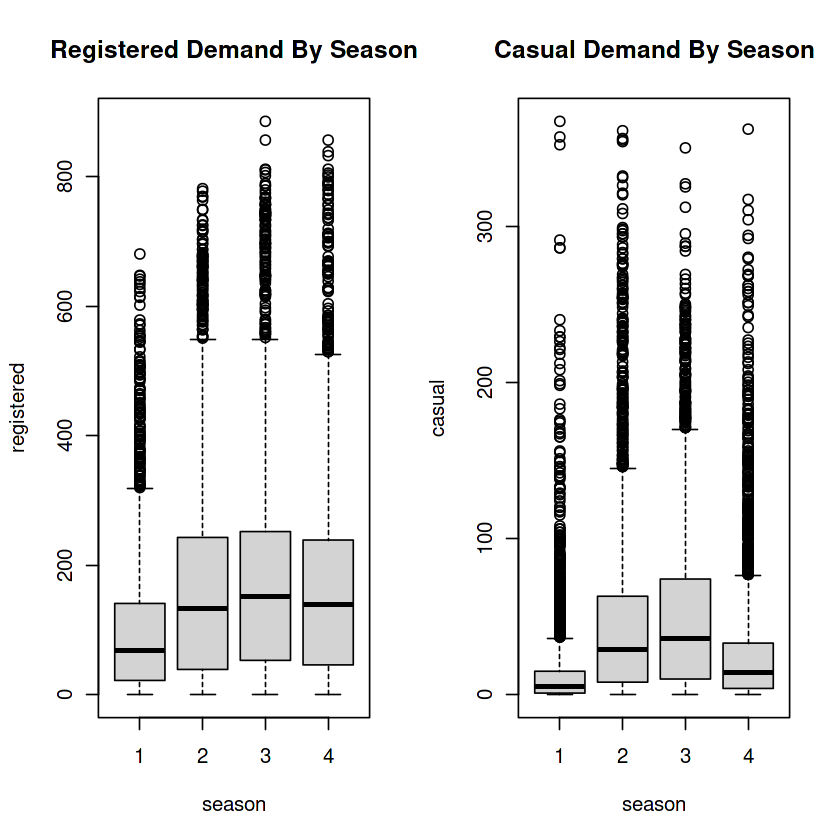

In [20]:
par(mfrow = c(1, 2))
boxplot(registered~season, data=train, main = "Registered Demand By Season")
boxplot(casual~season, data=train, main = "Casual Demand By Season")

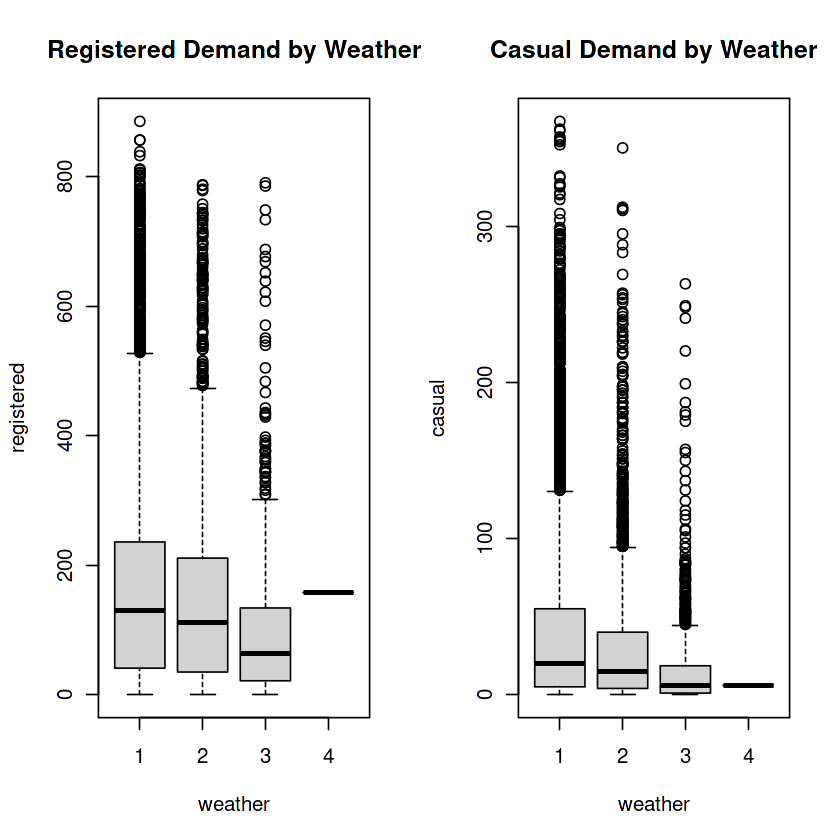

In [21]:
par(mfrow = c(1, 2))
boxplot(registered~weather, data=train, main = "Registered Demand by Weather")
boxplot(casual~weather, data=train, main = "Casual Demand by Weather")

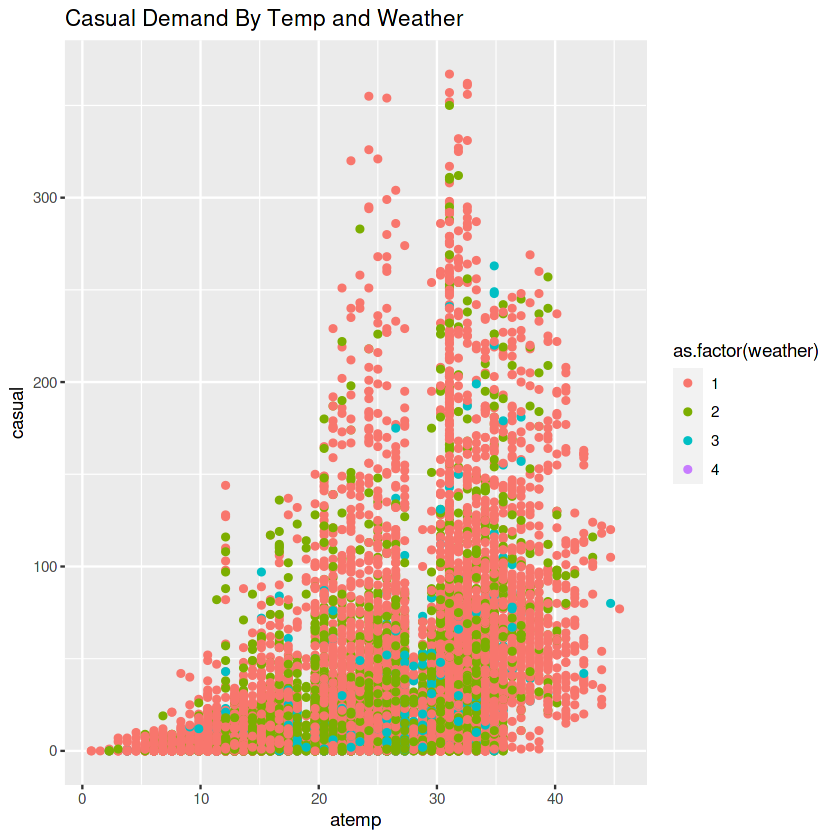

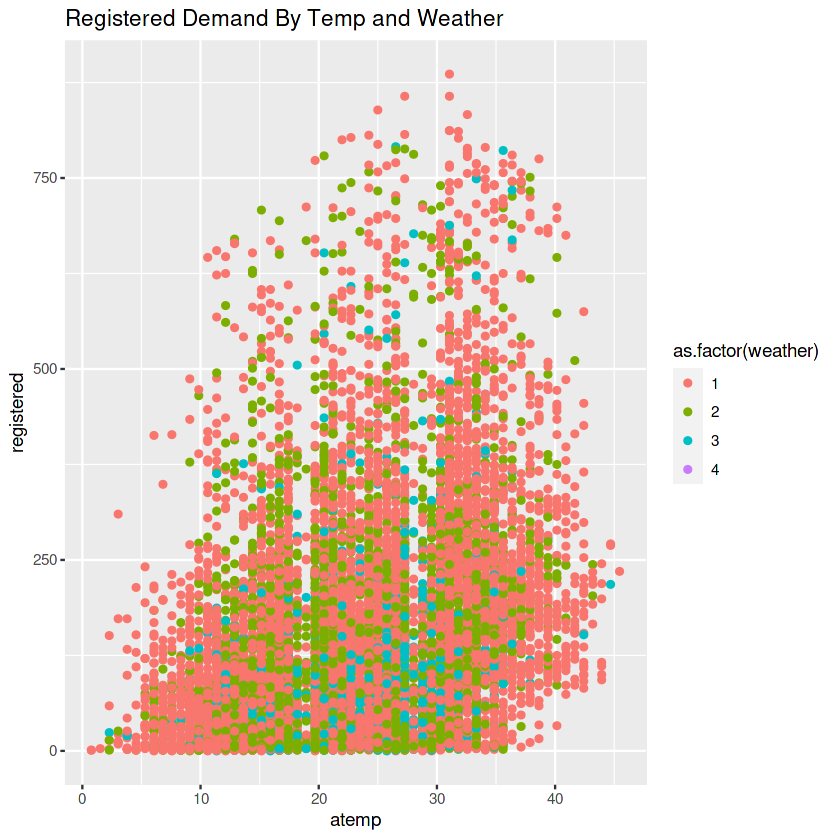

In [22]:
ggplot(train, aes(x = atemp, y = casual, col = as.factor(weather))) +
  geom_point()+
  ggtitle("Casual Demand By Temp and Weather")
ggplot(train, aes(x = atemp, y = registered, col = as.factor(weather))) +
  geom_point()+
  ggtitle("Registered Demand By Temp and Weather")

In [23]:
train$season = as.factor(train$season)
test$season = as.factor(test$season)

train$holiday = as.factor(train$holiday)
test$holiday = as.factor(test$holiday)

train$workingday = as.factor(train$workingday)
test$workingday = as.factor(test$workingday)

train$weather = as.factor(train$weather)
test$weather = as.factor(test$weather)

train$season = as.factor(train$season)
test$season = as.factor(test$season)

In [24]:
set.seed(6)
train.index = sample(dim(train)[1], 8615, replace = F)
train.train = train[train.index,]
train.validate = train[-train.index,]

In [25]:
# Data prep for glmnet function
x_casual = model.matrix(casual~date+season+holiday+workingday+weather+temp+atemp+humidity+windspeed+hour+day+year+quarter_year+hour_bin_casual+casual_outlier_day, data = train.train)[,-1]
y_casual = train.train[,"casual"]
y_casual = log(y_casual+1)
x_registered = model.matrix(registered~date+season+holiday+workingday+weather+temp+atemp+humidity+windspeed+hour+day+year+quarter_year+hour_bin_casual+casual_outlier_day, data = train.train)[,-1]
y_registered = train.train[,"registered"]
y_registered = log(y_registered+1)
# Model training using the 1 standard error arrpoach to selecting the best lambda value and most parsimonious model. 
casual_enet = glmnet(x_casual, y_casual, alpha = .75, lambda = cv.glmnet(x_casual, y_casual)$lambda.1se)
registered_enet = glmnet(x_registered, y_registered, alpha = .75, lambda = cv.glmnet(x_registered, y_registered)$lambda.1se)

In [26]:
# Transform the validation sets to the same format as the training matrix
casual_validate = model.matrix(casual~date+season+holiday+workingday+weather+temp+atemp+humidity+windspeed+hour+day+year+quarter_year+hour_bin_casual+casual_outlier_day, data = train.validate)[,-1]
registered_validate = model.matrix(casual~date+season+holiday+workingday+weather+temp+atemp+humidity+windspeed+hour+day+year+quarter_year+hour_bin_casual+casual_outlier_day, data = train.validate)[,-1]
# Predicting demand for validation set
predict_casual1 = predict(casual_enet, casual_validate) 
predict_registered1 = predict(registered_enet, registered_validate)
# Combining types of demand and trandforming back to original scale
predict_count1 = (exp(predict_casual1)-1) + (exp(predict_registered1)-1)
library(MLmetrics)
RMSLE(predict_count1, train.validate$count)

[1] 0.8580969

In [27]:
library(randomForest)
casual_rf = randomForest(log(casual+1)~date+season+holiday+workingday+weather+temp+atemp+humidity+windspeed+hour+day+year+quarter_year+hour_bin_casual+casual_outlier_day, data = train.train, n.tree = 500, importance = T)
registered_rf = randomForest(log(registered+1)~date+season+holiday+workingday+weather+temp+atemp+humidity+windspeed+hour+day+year+quarter_year+hour_bin_registered+registered_outlier_day, data = train.train, n.tree = 500, importance = T)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin




In [28]:
#casual_model
#registered_model
# Predicting demand for both types on the validation data
predict_casual2 = predict(casual_rf, train.validate) 
predict_registered2 = predict(registered_rf, train.validate)
# Combining types of demand and trandforming back to original scale
predict_count2 = (exp(predict_casual2)-1) + (exp(predict_registered2)-1)
RMSLE(predict_count2, train.validate$count)

[1] 0.4000389

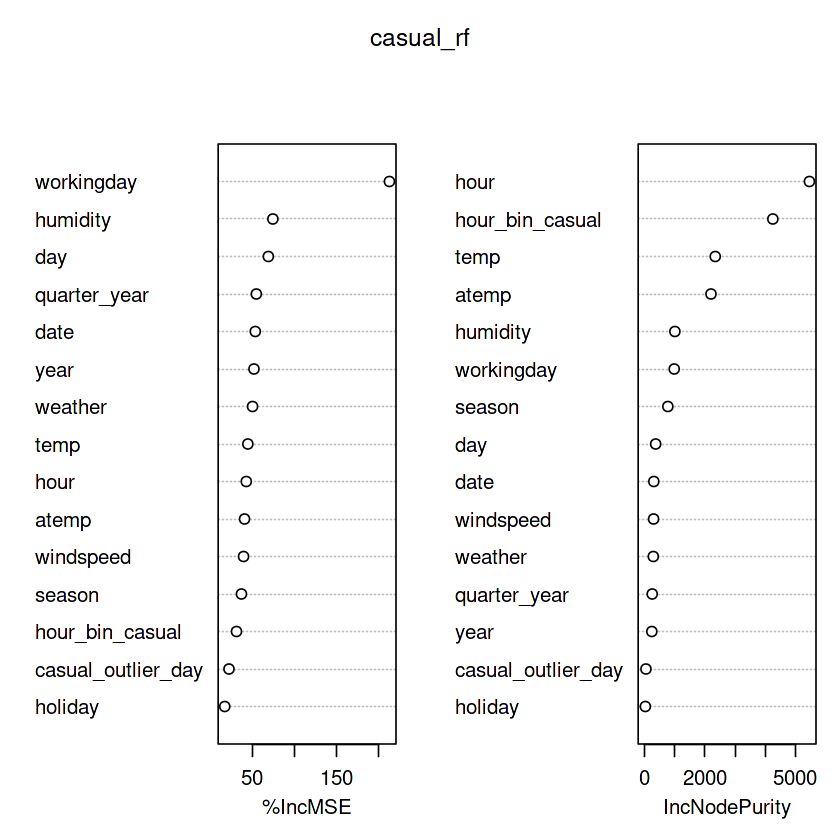

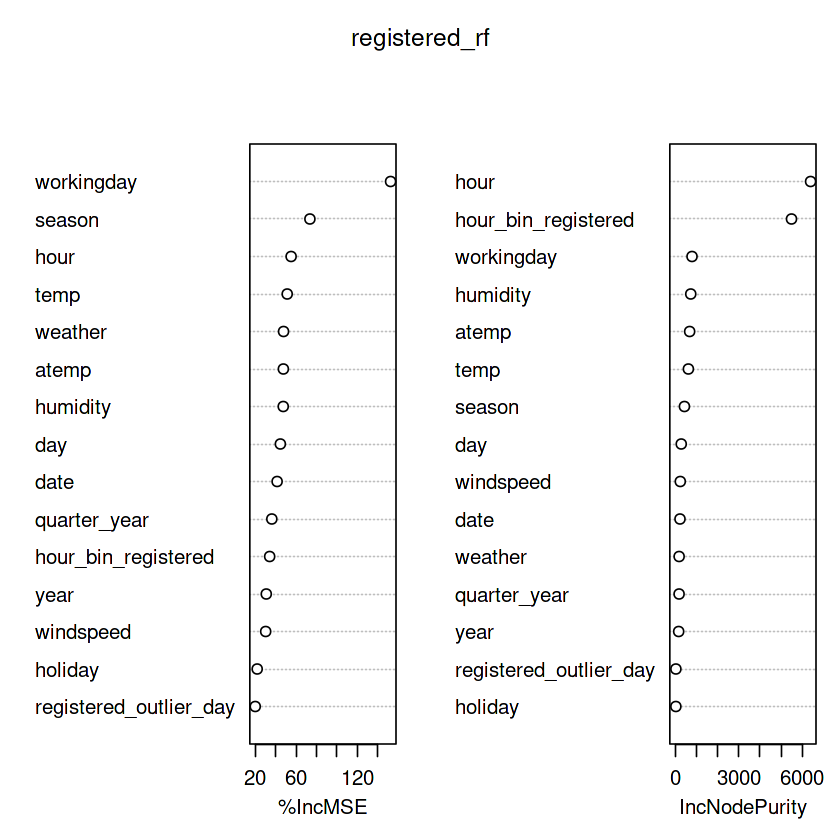

In [29]:
#Variable importance measures for random forest models
varImpPlot(casual_rf)
varImpPlot(registered_rf)

In [30]:
casual_model = randomForest(log(casual+1)~date+season+holiday+workingday+weather+temp+atemp+humidity+windspeed+hour+day+year+quarter_year+hour_bin_casual+casual_outlier_day, data = train, n.tree = 500, importance = T)
registered_model = randomForest(log(registered+1)~date+season+holiday+workingday+weather+temp+atemp+humidity+windspeed+hour+day+year+quarter_year+hour_bin_registered+registered_outlier_day, data = train, n.tree = 500, importance = T)

In [31]:
casual_pred = predict(casual_model, test)
registered_pred = predict(registered_model, test)
count = (exp(casual_pred)-1) + (exp(registered_pred)-1)
test = cbind(test, count)
final_submission = test[,c("datetime", "count")]

In [32]:
write.csv(final_submission,"submission.csv")